# Flood Observatory - GRACE Analysis

<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 06/07/2016 <br/>
</h3>

# Setup

In [150]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio 

In [151]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [152]:
# define directories
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

# Load Data

## GRACE MASCON-CRI

In [268]:
# GRACE MASCON-CRI Matlab files
mat_content_grace = sio.loadmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02.nc.mat')
mat_content_derivedMaps = sio.loadmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_derivedMaps.nc.mat')
mat_content_dateVectors = sio.loadmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_dateVectors.nc.mat')

grace_lwe_perc_adj = mat_content_derivedMaps['lwe_thickness_percentiles_adj']
grace_lwe_climRemStd_adj = mat_content_derivedMaps['lwe_thickness_climRemStd_adj']
grace_lwe_climatology_adj = mat_content_derivedMaps['lwe_thickness_climatology_adj']
grace_time_datestr = mat_content_dateVectors['time_datestr']

In [154]:
# GRACE MASCON-CRI data description
print sio.whosmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02.nc.mat')
print sio.whosmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_derivedMaps.nc.mat')
print sio.whosmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_dateVectors.nc.mat')

[('lat', (360, 1), 'double'), ('lon', (720, 1), 'double'), ('lwe_thickness', (720, 360, 152), 'double'), ('time', (152, 1), 'double'), ('uncertainty', (720, 360, 152), 'double')]
[('lwe_thickness_percentiles', (720, 360, 152), 'double'), ('lwe_thickness_percentiles_adj', (360, 720, 152), 'double'), ('lwe_thickness_climRemStd', (720, 360, 152), 'double'), ('lwe_thickness_climRemStd_adj', (360, 720, 152), 'double'), ('lwe_thickness_climRem', (720, 360, 152), 'double'), ('lwe_thickness_climRem_adj', (360, 720, 152), 'double'), ('lwe_thickness_climatology', (720, 360, 152), 'double'), ('lwe_thickness_climatology_adj', (720, 360, 152), 'double')]
[('time_datenum', (152, 1), 'double'), ('time_datestr', (152,), 'char'), ('time_datestr_cell', (152, 1), 'cell'), ('time_dayOfYear', (152, 1), 'double'), ('time_month', (152, 1), 'double'), ('time_year', (152, 1), 'double')]


## Flood Observatory

In [197]:
# FO data previously cleaned by FloodObservatory_Preprocess.py
df_flood_grace = pd.read_csv(dir_python_data + 'df_flood_grace.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)
df_flood_grace.head(5)

,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,Magnitude (M)**,Country,Other,Centroid X,Centroid Y
0,4356.0,8-May-16,08-May-16,11-May-16,4.0,0.0,0.0,Heavy Rain,1.0,197079.53,5.9,China,0,112.9520,24.75320
1,4355.0,20-Apr-16,20-Apr-16,1-May-16,12.0,18.0,3000.0,Heavy Rain,1.5,70517.68,6.1,India,Bangladesh,95.6068,27.46400
2,4354.0,8-May-16,08-May-16,11-May-16,4.0,5.0,3000.0,Heavy Rain,1.5,23311.63,5.1,Dominican Republic,Haiti,-71.1644,18.99420
3,4353.0,6-May-16,06-May-16,11-May-16,6.0,49.0,2000.0,Heavy Rain,1.5,18269.24,5.2,Rwanda,0,30.0118,-2.05650
4,4352.0,13-Apr-16,13-Apr-16,22-Apr-16,10.0,0.0,0.0,Tropical Storm Fantala,1.0,117235.21,6.1,Kenya,Tanzania,38.3442,-4.71451


# Merge Data

## Location

In [198]:
# Conversion: Centroid Fields

# convert Centroid X
df_flood_grace['Centroid X GRACE'] = df_flood_grace['Centroid X']
a_centroid_x = df_flood_grace['Centroid X GRACE'].values

for i in range(a_centroid_x.size):
    centroid_x = a_centroid_x[i]
    
    if centroid_x < 0:
        a_centroid_x[i] = (180 - (centroid_x * -1)) + 180

df_flood_grace['Centroid X GRACE'] = a_centroid_x
df_flood_grace['Centroid X GRACE'] = df_flood_grace['Centroid X GRACE'] * 2


# convert Centroid Y
df_flood_grace['Centroid Y GRACE'] = df_flood_grace['Centroid Y']
a_centroid_y = df_flood_grace['Centroid Y GRACE'].values

for i in range(a_centroid_y.size):
    centroid_y = a_centroid_y[i]
    
    a_centroid_y[i] = centroid_y + 90
        
df_flood_grace['Centroid Y GRACE'] = a_centroid_y
df_flood_grace['Centroid Y GRACE'] = df_flood_grace['Centroid Y GRACE'] * 2
df_flood_grace['Centroid Y GRACE'] = 360 - df_flood_grace['Centroid Y GRACE']


## Time

In [200]:
# Date Association

# convert GRACE times to Series
s_grace_time_datestr = pd.Series(grace_time_datestr)

# empty vectors
diff = np.zeros(s_grace_time_datestr.size)
min_diff = np.zeros(df_flood_grace.shape[0])
min_diff_ix = np.zeros(df_flood_grace.shape[0])

# find GRACE MASCON index for each flood
for i in range(df_flood_grace.shape[0]):
    
    date_flood = df_flood_grace['Began'].iloc[i]
    datetime_flood = dt.datetime.strptime(date_flood, "%d-%b-%y")
    
    for j in range(s_grace_time_datestr.size):
        
        date_mascon = s_grace_time_datestr.iloc[j]
        datetime_mascon = dt.datetime.strptime(date_mascon, "%d-%b-%Y")
    
        # diff b/w grace and flood
        diff[j] = (datetime_flood - datetime_mascon).days
        
        # negative values indicate MASCONs that occur after flood
        diff[diff < 0] = diff.max()
        
        
    # minimum difference
    min_diff[i] = diff.min()
    min_diff_ix[i] = diff.argmin() #returns index of first occurance of min value

# add date association metrics to dataframe
df_flood_grace['Days from MASCON'] = min_diff
df_flood_grace['MASCON Index'] = min_diff_ix

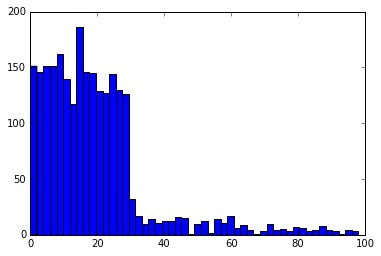

In [246]:
# plot histogram of differences b/w flood and GRACE-MASCON dates
plt.hist(df_flood_grace['Days from MASCON'], bins=50)
plt.show()

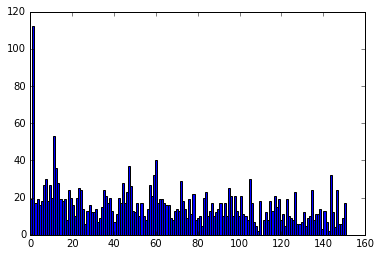

In [203]:
# plot histogram of GRACE MASCON time indexes of floods
plt.hist(df_flood_grace['MASCON Index'], bins = grace_time_datestr.size)
plt.show()

In [237]:
# display merged flood dataframe
df_flood_grace.head(5)

,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,...,Country,Other,Centroid X,Centroid Y,Centroid X GRACE,Centroid Y GRACE,Days from MASCON,MASCON Index,GRACE %,GRACE ClimRem Std
0,4356.0,8-May-16,08-May-16,11-May-16,4.0,0.0,0.0,Heavy Rain,1.0,197079.53,...,China,0,112.9520,24.75320,225.9040,130.49360,52.0,151.0,100.000000,2.851769
1,4355.0,20-Apr-16,20-Apr-16,1-May-16,12.0,18.0,3000.0,Heavy Rain,1.5,70517.68,...,India,Bangladesh,95.6068,27.46400,191.2136,125.07200,34.0,151.0,9.210526,-0.379583
2,4354.0,8-May-16,08-May-16,11-May-16,4.0,5.0,3000.0,Heavy Rain,1.5,23311.63,...,Dominican Republic,Haiti,-71.1644,18.99420,577.6712,142.01160,52.0,151.0,32.894737,0.318909
3,4353.0,6-May-16,06-May-16,11-May-16,6.0,49.0,2000.0,Heavy Rain,1.5,18269.24,...,Rwanda,0,30.0118,-2.05650,60.0236,184.11300,50.0,151.0,84.868421,0.827128
4,4352.0,13-Apr-16,13-Apr-16,22-Apr-16,10.0,0.0,0.0,Tropical Storm Fantala,1.0,117235.21,...,Kenya,Tanzania,38.3442,-4.71451,76.6884,189.42902,27.0,151.0,88.815789,1.467757


# Add GRACE Features

## Percentiles

In [204]:
# create empty vectors
perc = np.zeros(df_flood_grace.shape[0])

# extract percentiles
for i in range(df_flood_grace.shape[0]):
    x = int(round(df_flood_grace['Centroid X GRACE'].iloc[i]))
    y = int(round(df_flood_grace['Centroid Y GRACE'].iloc[i]))
    time_ix = int(min_diff_ix[i])
    
    if x == 720:
        x = 719
    
    perc[i] = grace_lwe_perc_adj[y-1, x-1,  time_ix] 
    
df_flood_grace['GRACE %'] = perc

## Standard Deviations (Climatology Removed)

In [214]:
# create empty vectors
climRemStd = np.zeros(df_flood_grace.shape[0])

# extract percentiles
for i in range(df_flood_grace.shape[0]):
    x = int(round(df_flood_grace['Centroid X GRACE'].iloc[i]))
    y = int(round(df_flood_grace['Centroid Y GRACE'].iloc[i]))
    time_ix = int(min_diff_ix[i])
    
    if x == 720:
        x = 719
    
    climRemStd[i] = grace_lwe_climRemStd_adj[y-1, x-1,  time_ix] 
    
df_flood_grace['GRACE ClimRem Std'] = climRemStd

# Remove Non-Land Floods

In [215]:
# list of floods outside land mask
df_flood_grace_ocean = df_flood_grace[df_flood_grace['GRACE %'] == -1]
df_flood_grace_ocean[['Country','Centroid X GRACE', 'Centroid Y GRACE', 'MASCON Index']].head(5)

,Country,Centroid X GRACE,Centroid Y GRACE,MASCON Index
27,Fiji,355.8560,215.55080,150.0
44,Maldives,146.3784,180.28859,147.0
50,Bahamas,572.3352,135.01680,147.0
101,Chile,574.1576,268.20660,144.0
123,Angola,27.3622,197.63328,141.0


In [216]:
df_flood_grace_land = df_flood_grace[~(df_flood_grace['GRACE %'] == -1)]

# Plots

In [217]:
# set dataframe for plotting
df = df_flood_grace_land
df.shape

(2261, 21)

In [271]:
df.head(5)

,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,...,Country,Other,Centroid X,Centroid Y,Centroid X GRACE,Centroid Y GRACE,Days from MASCON,MASCON Index,GRACE %,GRACE ClimRem Std
0,4356.0,8-May-16,08-May-16,11-May-16,4.0,0.0,0.0,Heavy Rain,1.0,197079.53,...,China,0,112.9520,24.75320,225.9040,130.49360,52.0,151.0,100.000000,2.851769
1,4355.0,20-Apr-16,20-Apr-16,1-May-16,12.0,18.0,3000.0,Heavy Rain,1.5,70517.68,...,India,Bangladesh,95.6068,27.46400,191.2136,125.07200,34.0,151.0,9.210526,-0.379583
2,4354.0,8-May-16,08-May-16,11-May-16,4.0,5.0,3000.0,Heavy Rain,1.5,23311.63,...,Dominican Republic,Haiti,-71.1644,18.99420,577.6712,142.01160,52.0,151.0,32.894737,0.318909
3,4353.0,6-May-16,06-May-16,11-May-16,6.0,49.0,2000.0,Heavy Rain,1.5,18269.24,...,Rwanda,0,30.0118,-2.05650,60.0236,184.11300,50.0,151.0,84.868421,0.827128
4,4352.0,13-Apr-16,13-Apr-16,22-Apr-16,10.0,0.0,0.0,Tropical Storm Fantala,1.0,117235.21,...,Kenya,Tanzania,38.3442,-4.71451,76.6884,189.42902,27.0,151.0,88.815789,1.467757


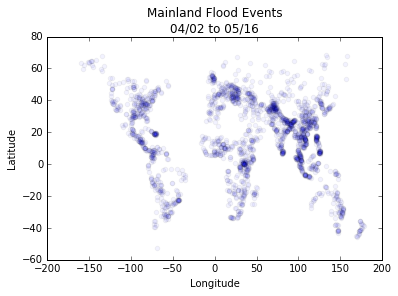

In [274]:
# frequency of floods across the world
x = df['Centroid X']
y = df['Centroid Y']

plt.scatter(x, y, alpha=0.05)
plt.title('Mainland Flood Events\n04/02 to 05/16')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig(dir_figures + 'floods_events.png')

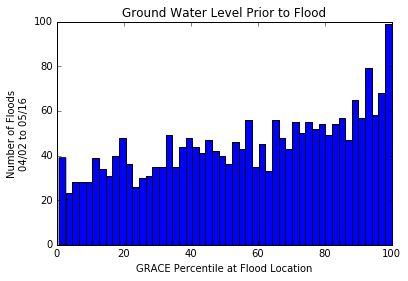

In [235]:
# GRACE levels during flood events
plt.hist(df['GRACE %'], bins=50)
plt.title('Ground Water Level Prior to Flood')
plt.xlabel('GRACE Percentile at Flood Location')
plt.ylabel('Number of Floods\n04/02 to 05/16')
plt.savefig(dir_figures + 'floods_GRACEPercentiles.png')

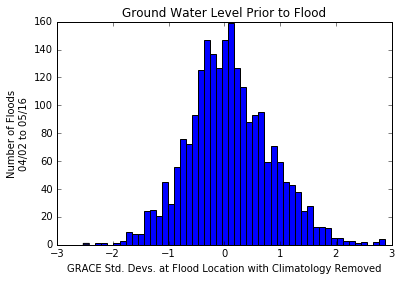

Mean:  0.0919934564906


In [247]:
# GRACE levels during flood events
plt.hist(df['GRACE ClimRem Std'], bins=50)
plt.title('Ground Water Level Prior to Flood')
plt.xlabel('GRACE Std. Devs. at Flood Location with Climatology Removed')
plt.ylabel('Number of Floods\n04/02 to 05/16')
plt.savefig(dir_figures + 'floods_GRACEClimRemStd.png')
plt.show()

print 'Mean: ', mean(df['GRACE ClimRem Std'])

# Functions

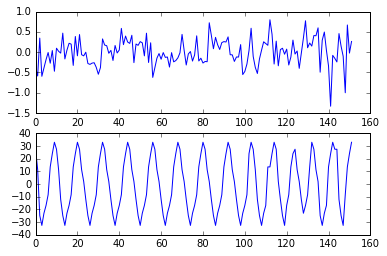

In [270]:
# co-ordinates
d1 = 200
d2 = 600
grace = grace_lwe_climRemStd_adj
climatology = grace_lwe_climatology_adj
    
# create timeseries
grace_timeseries = grace[d1,d2,:]
climatology_timeseries = climatology[d1,d2,:]

# find floods at grid location

    
# plot timeseries
plt.subplot(2,1,1)
plt.plot(grace_timeseries)
plt.subplot(2,1,2)
plt.plot(climatology_timeseries)

plt.show()

In [267]:
shape(climatology)

(720, 360, 152)